In [1]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import json
import pandas as pd
import torch.nn.functional as F

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [17]:
path_dir_sc_bn = "work_dirs/segformer_mit-b0_8xb2-160k_ade20k-512x512/20230622_154449"
path_dir_harcoded_bn = "work_dirs/segformer_mit-b0_8xb2-160k_ade20k-512x512/20230627_150517"
path_dir_set5 = "work_dirs/segformer_mit-b0_8xb2-160k_ade20k-512x512/20230628_131036"
path_hardcoded_new_optim = "work_dirs/segformer_mit-b0_8xb2-160k_ade20k-512x512/20230628_151930"
path_hardcoded_new_optim_corr_shape = "work_dirs/segformer_mit-b0_8xb2-160k_ade20k-512x512/20230629_150333"
path_feedformer = "work_dirs/feedformer.b0.512x512.ade.160k_julian/20230703_151459"
# path_file = "model_init_2.pth"

In [3]:
# state_dict = torch.load(path_file)#["state_dict"]
# alphas_init = [state_dict[e] for e in state_dict if "alpha" in e][0]
# lambdas_init = nn.Sigmoid()(alphas_init)

In [9]:
def plot_results(path_dir):
    filenames = [filename for filename in os.listdir(path_dir) if filename.endswith("pth")]
    numbers = []
    for string in filenames:
        match = re.search(r'\d+', string)  # Extracts the first occurrence of one or more digits
        if match:
            number = int(match.group())  # Converts the matched string to an integer
            numbers.append(number)
    filenames = [tup[0] for tup in sorted(zip(filenames, numbers), key=lambda x:x[1])]

    alphas, lambdas = [], []

    for file in filenames:
        path_file = os.path.join(path_dir, file)
        try:
            state_dict = torch.load(path_file)["state_dict"]
        except:
            state_dict = torch.load(path_file)
        alpha_tens = [state_dict[e] for e in state_dict if "alpha" in e][0].to(torch.device("cpu"))
        lambda_tens = nn.Sigmoid()(alpha_tens)
        alphas.append(alpha_tens)
        lambdas.append(lambda_tens)

    alphas_torch = torch.concat(alphas)
    lambdas_torch = torch.concat(lambdas)

    numb_alpha_convergences = 10
    plt.title(f"{numb_alpha_convergences} randomly picked lambda convergences")
    for i in range(numb_alpha_convergences):
        idx_rand = np.random.randint(lambdas_torch.shape[-1])
        plt.plot(sorted(numbers), lambdas_torch[:, idx_rand, idx_rand], label=f"Idx: {idx_rand}")
        plt.ylim(0, 1)
        plt.ylabel("lambda")
        plt.xlabel("Iteration")
    
    return lambdas_torch

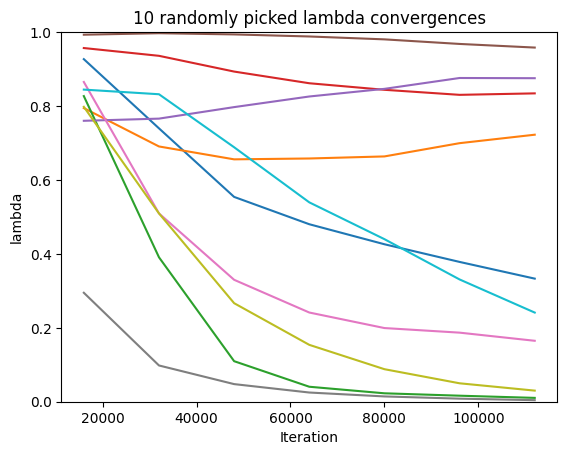

In [17]:
lambdas_torch = plot_results(path_dir_set5)

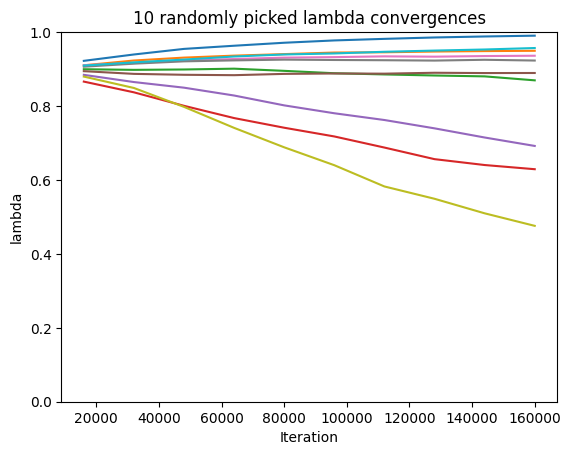

In [28]:
torch_lambdas = plot_results(path_hardcoded_new_optim)

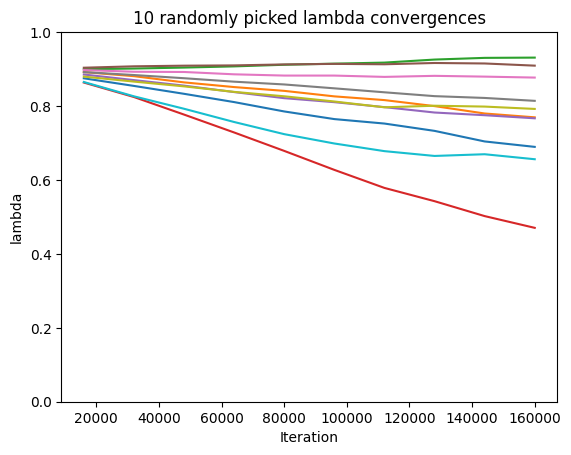

In [88]:
torch_lambdas2 = plot_results(path_hardcoded_new_optim_corr_shape)

In [125]:
from PIL import Image
from io import BytesIO
def create_lambdas_changing_gif(torch_lambdas):
        # Assuming `torch_lambdas` is a list of torch tensors
    # torch_lambdas = [...]

    # Create a list to store individual plot images
    plot_images = []

    # Generate plot images for each matrix
    for i, tensor in enumerate(torch_lambdas):
        plt.imshow(tensor, vmin=0, vmax=1)
        plt.colorbar()
        plt.title(f"Lambdas at iteration {16000 * (i + 1)}")
        plt.xlabel("embed_dim")
        plt.ylabel("token_dim")

        
        # Store the plot image in memory
        image_buffer = BytesIO()
        plt.savefig(image_buffer, format='png')
        image_buffer.seek(0)
        
        # Open the image from memory
        plot_image = Image.open(image_buffer)
        
        # Add the image to the list
        plot_images.append(plot_image)
        
        # Clear the plot for the next iteration
        plt.clf()

    # Save the list of images as a GIF
    plot_images[0].save("torch_lambdas.gif",
                        save_all=True,
                        append_images=plot_images[1:],
                        duration=500,
                        loop=0)

    # Clean up the image buffers
    for image_buffer in plot_images:
        image_buffer.close()

In [126]:
create_lambdas_changing_gif(torch_lambdas2)

<Figure size 640x480 with 0 Axes>

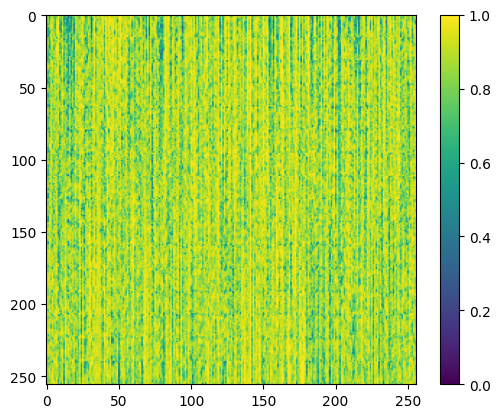

In [81]:
plt.imshow(torch_lambdas2[-1], vmin=0, vmax=1)
plt.colorbar()

Text(0.5, 1.0, 'Histogram of final lambda values at iter 160000')

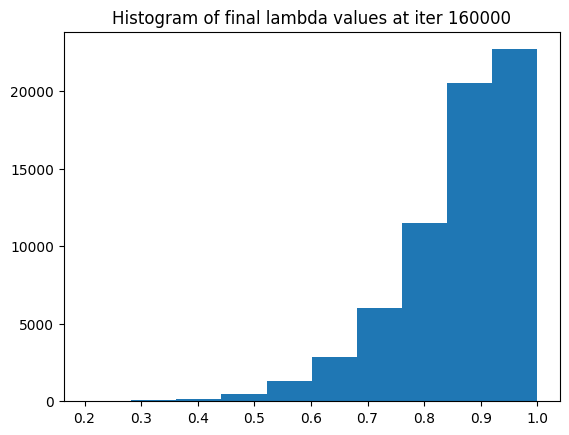

In [128]:
plt.hist(torch_lambdas2[-1].flatten())
plt.title("Histogram of final lambda values at iter 160000")

In [97]:
torch_lambdas2[-1] < 0.5

tensor([[False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        ...,
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False]])

In [96]:
lambdas_torch[-1].shape

torch.Size([224, 224])

(array([ 2.,  9., 18., 27., 40., 52., 47., 45., 14.,  2.]),
 array([0.70691609, 0.73461282, 0.76230955, 0.79000634, 0.81770307,
        0.8453998 , 0.87309653, 0.90079325, 0.92849004, 0.95618677,
        0.9838835 ]),
 <BarContainer object of 10 artists>)

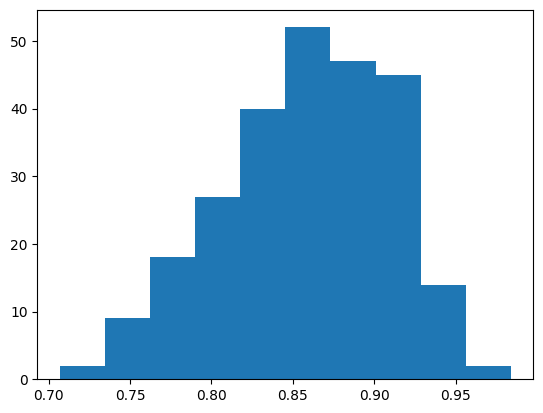

In [98]:
plt.hist(torch_lambdas2[-1].mean(0))

Text(0.5, 1.0, 'Boxplot of final lambda values at iter 160000')

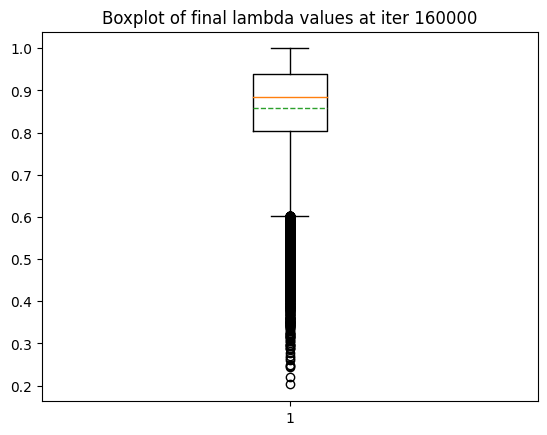

In [129]:
plt.boxplot(torch_lambdas2[-1].flatten(), showmeans=True, meanline=True)
plt.title("Boxplot of final lambda values at iter 160000")

In [119]:
torch_lambdas2[-1][0]

tensor([0.5040, 0.8938, 0.7606, 0.9377, 0.9829, 0.8514, 0.9524, 0.9500, 0.9694,
        0.8724, 0.9565, 0.9660, 0.7792, 0.9635, 0.9722, 0.9284, 0.8763, 0.6084,
        0.7113, 0.9483, 0.9706, 0.8805, 0.9791, 0.6645, 0.9897, 0.9257, 0.6057,
        0.7094, 0.5942, 0.9306, 0.9658, 0.4171, 0.7021, 0.9943, 0.9515, 0.7870,
        0.9760, 0.9401, 0.9783, 0.8188, 0.9406, 0.9878, 0.8263, 0.6408, 0.9700,
        0.9166, 0.9026, 0.7236, 0.8794, 0.6111, 0.9069, 0.9741, 0.9827, 0.8506,
        0.9791, 0.9752, 0.8797, 0.9623, 0.9625, 0.9082, 0.7004, 0.5796, 0.8389,
        0.8857, 0.9173, 0.8937, 0.9109, 0.9015, 0.9647, 0.6912, 0.9641, 0.6675,
        0.8865, 0.9324, 0.9055, 0.9892, 0.9747, 0.6605, 0.5132, 0.9453, 0.7271,
        0.8756, 0.9935, 0.7362, 0.9564, 0.9131, 0.4068, 0.9927, 0.9466, 0.8948,
        0.8380, 0.8249, 0.9874, 0.6534, 0.5548, 0.9727, 0.9238, 0.9892, 0.9087,
        0.7939, 0.8361, 0.7987, 0.9639, 0.7604, 0.8428, 0.4102, 0.4476, 0.9111,
        0.6802, 0.6326, 0.9559, 0.9755, 

Text(0.5, 1.0, 'Each boxplot represents one token (10 tokens dims in total)')

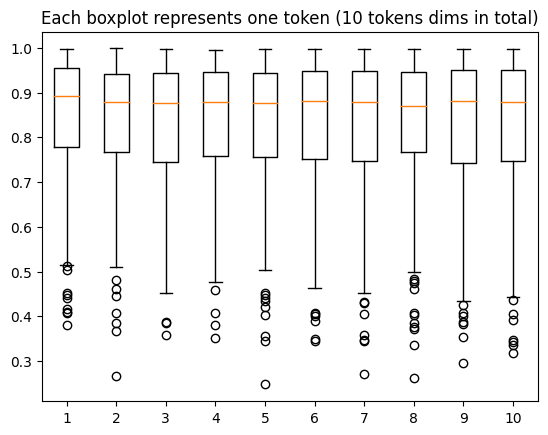

In [124]:
plt.boxplot(torch_lambdas2[-1][0:10])
plt.title("Each boxplot represents one token (10 tokens dims in total)")

(array([ 1.,  6., 10., 18., 37., 42., 54., 57., 27.,  4.]),
 array([0.71204853, 0.73975003, 0.76745158, 0.79515314, 0.82285464,
        0.85055614, 0.87825769, 0.90595925, 0.93366075, 0.96136224,
        0.9890638 ]),
 <BarContainer object of 10 artists>)

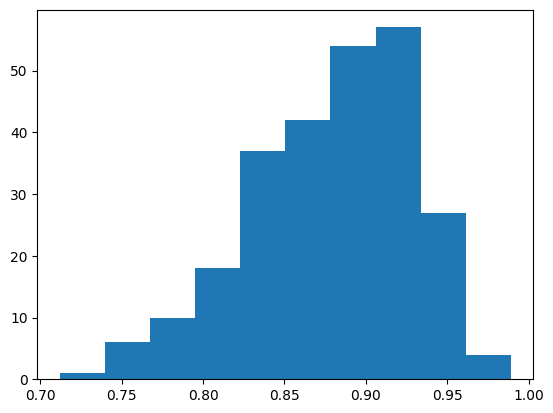

In [103]:
plt.hist(torch_lambdas2[-1].median(0)[0])

(array([10948.,  3858.,  3043.,  2876.,  2771.,  2768.,  2994.,  3506.,
         4577., 12835.]),
 array([6.37351505e-09, 1.00000009e-01, 2.00000003e-01, 3.00000012e-01,
        4.00000006e-01, 5.00000000e-01, 6.00000024e-01, 6.99999988e-01,
        8.00000012e-01, 8.99999976e-01, 1.00000000e+00]),
 <BarContainer object of 10 artists>)

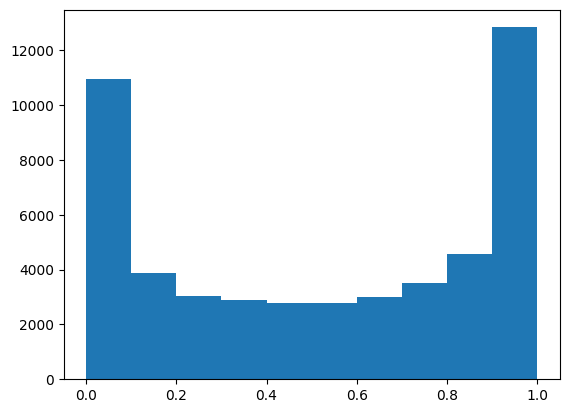

In [15]:
plt.hist(lambdas_torch[-1].flatten())

In [73]:
lambd_resized = F.interpolate(torch_lambdas[-1].unsqueeze(0).unsqueeze(0), (256, 256))
lambd_resized = lambd_resized.squeeze(0).squeeze(0)
lambd_resized[0].reshape(16, 16).min()

tensor(0.2533)

In [74]:
lambd_resized[0].reshape(16, 16).max()

tensor(0.9995)

In [59]:
torch_lambdas[-1]

tensor([[0.4758, 0.8666, 0.7272,  ..., 0.8270, 0.7496, 0.9759],
        [0.5043, 0.8248, 0.6229,  ..., 0.7265, 0.7343, 0.9312],
        [0.5587, 0.7953, 0.5993,  ..., 0.6574, 0.6858, 0.8398],
        ...,
        [0.7672, 0.7651, 0.7931,  ..., 0.8689, 0.9580, 0.9136],
        [0.7526, 0.7776, 0.8049,  ..., 0.9055, 0.9151, 0.8813],
        [0.6639, 0.8597, 0.8574,  ..., 0.9662, 0.8897, 0.8465]])

In [50]:
def get_params_all_stages(path_dir):
    filenames = [filename for filename in os.listdir(path_dir) if filename.endswith("pth")]
    numbers = []
    for string in filenames:
        match = re.search(r'\d+', string)  # Extracts the first occurrence of one or more digits
        if match:
            number = int(match.group())  # Converts the matched string to an integer
            numbers.append(number)
    filenames = [tup[0] for tup in sorted(zip(filenames, numbers), key=lambda x:x[1])]

    try:
        state_dict = torch.load(os.path.join(path_dir, filenames[0]))["state_dict"]
    except:
        state_dict = torch.load(path_dir, filenames[0])
    num_parameters = len([state_dict[e].shape for e in state_dict if "alpha" in e])

    alphas = [[] for _ in range(num_parameters)]
    lambdas = [[] for _ in range(num_parameters)]
    for file in filenames:
        path_file = os.path.join(path_dir, file)
        try:
            state_dict = torch.load(path_file)["state_dict"]
        except:
            state_dict = torch.load(path_file)
        
        alpha_tens = [state_dict[e].to(torch.device("cpu")) for e in state_dict if "alpha" in e]
        
        for i in range(num_parameters):
            alphas[i].append(alpha_tens[i])
            lambdas[i].append(nn.Sigmoid()(alpha_tens[i]))

    # alphas_torch = torch.concat(alphas)
    # lambdas_torch = torch.concat(lambdas)

    # numb_alpha_convergences = 10
    # plt.title(f"{numb_alpha_convergences} randomly picked lambda convergences")
    # for i in range(numb_alpha_convergences):
    #     idx_rand = np.random.randint(lambdas_torch.shape[-1])
    #     plt.plot(sorted(numbers), lambdas_torch[:, idx_rand, idx_rand], label=f"Idx: {idx_rand}")
    #     plt.ylim(0, 1)
    #     plt.ylabel("lambda")
    #     plt.xlabel("Iteration")
    
    return alphas, lambdas

In [51]:
alphas, lambdas = get_params_all_stages(path_feedformer)

In [95]:
def plot_results(style="plot", y_lim=None):
    """
    Args:
        style : string
            style in "plot", "hist", "box"
    """
    x = y = int(len(lambdas) ** 0.5)
    fig, axs = plt.subplots(x, y, figsize=(8, 7))
    for i in range(len(lambdas)):
        row, col = int(i / x),  i  % x
        params = torch.cat(lambdas[i])
        if style == "plot":
            x_vals = [(i + 1) * 16000 for i in range(len(params))]
            axs[row][col].plot(x_vals, params)
            axs[row][col].set_title(f"Stage {i + 1} with num params: {len(params[0])}")
            axs[row][col].set_xticks
            axs[row][col].set_ylim(y_lim)
        if style == "hist":
            axs[row][col].hist(params[-1].flatten())
            axs[row][col].set_title(f"Stage {i + 1} with num params: {len(params[0])}")
        # axs[row][col].set_ylim((0, 1))
        if style == "box":
            axs[row][col].boxplot(params[-1], showmeans=True, meanline=True)
            axs[row][col].set_title(f"Stage {i + 1} with num params: {len(params[0])}")
            axs[row][col].set_ylim(y_lim)


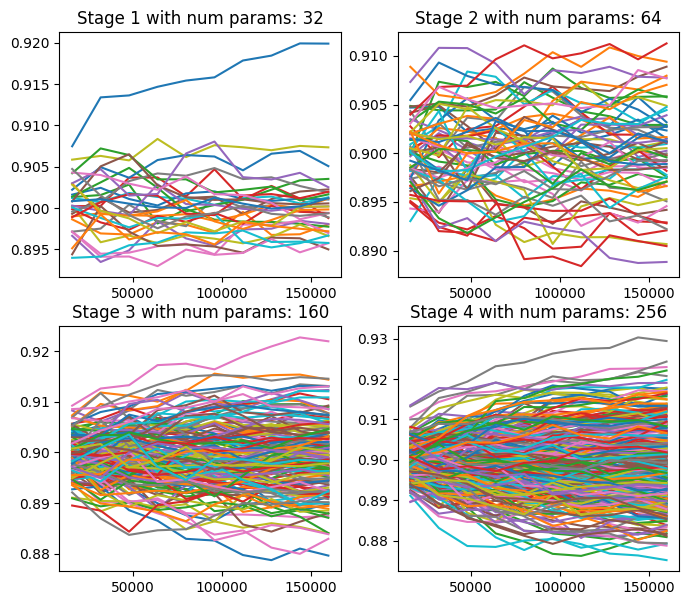

In [96]:
plot_results(style="plot")

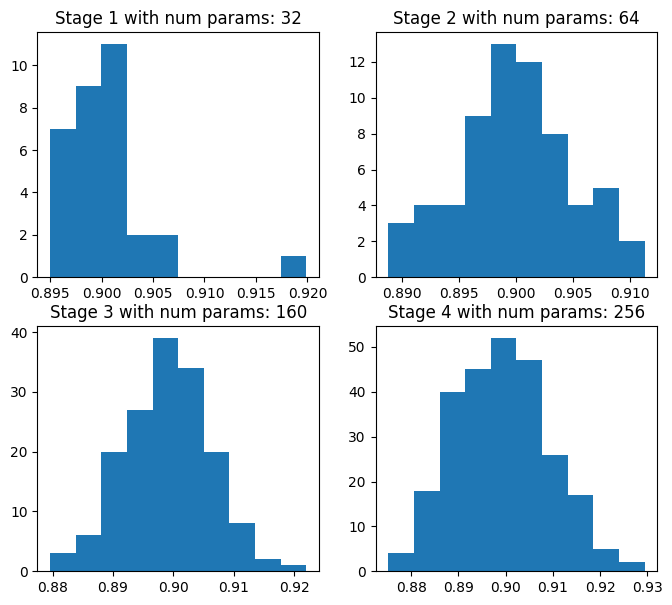

In [97]:
plot_results(style="hist")

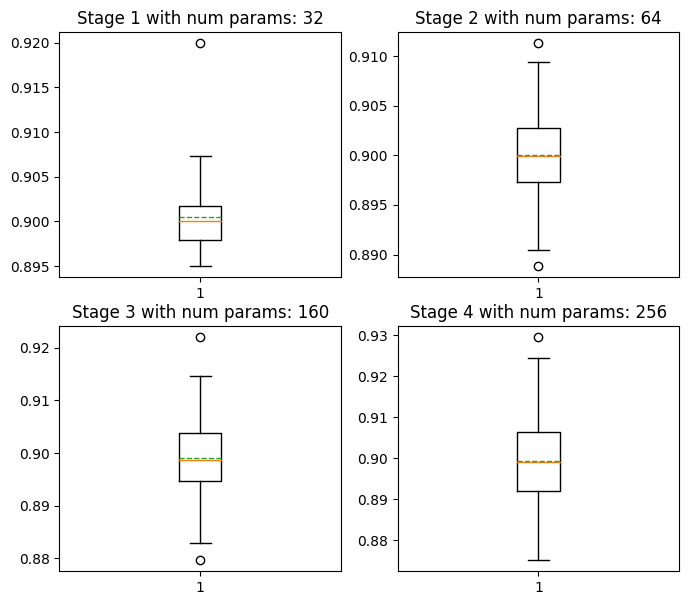

In [98]:
plot_results(style="box")